# Machine Learning- reconstruct Image from partial/incomplete image

https://github.com/carpentries-incubator/SDC-BIDS-fMRI.git

https://towardsdatascience.com/medical-image-pre-processing-with-python-d07694852606

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [ ]:
from keras.layers import Layer, Input, Conv2D, Activation, add, BatchNormalization, UpSampling2D, ZeroPadding2D, Conv2DTranspose, Flatten, MaxPooling2D, AveragePooling2D
from keras_contrib.layers.normalization import InstanceNormalization, InputSpec
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.backend import mean
from keras.models import Model, model_from_json
from keras.utils import plot_model
from keras.engine.topology import Container

from collections import OrderedDict
from scipy.misc import imsave, toimage  # has depricated
import numpy as np
import random
import datetime
import time
import json
import math
import csv
import sys
import os

import keras.backend as K
import tensorflow as tf

# 0/Get Image

In [31]:

# Reading an animated GIF file using Python Image Processing Library - Pillow

from PIL import Image

from PIL import GifImagePlugin

 

imageObject = Image.open("OASIS1/OAS1_0001_MR1/RAW/OAS1_0001_MR1_mpr-1_anon_sag_66.gif")

print(imageObject.is_animated)

print(imageObject.n_frames)

 

# Display individual frames from the loaded animated GIF file

for frame in range(0,imageObject.n_frames):

    imageObject.seek(frame)

    imageObject.show()

False
1


In [ ]:
# # MRI Images In Python
# Python doesn't come with as many features/functions as Matlab does "out of the box", most things need to be added as a separate package. Here we'll be using one package to read/write MRI data and another to view them while we're programming.
# 
# ## Reading/Writing MRI Data
# MRI data can be read using the [nibabel](https://github.com/nipy/nibabel) package. It's very comprehensive and can cope with `nii.gz`, `.img/.hdr`, Philips `.PAR/.REC` and FreeSurfer `.mgz` files. It does more than just read in the array of voxels, it can also deal with header and affine information and comes with some useful tools to manipulate data.
# 
# ## Visualising Data
# I tend to use matplotlib to view images as I'm programming. Its more designed for making graphs but is pretty useful to quickly view an image.


# First we need to tell Python what extra packages we want to use.


import nibabel as nib # We'll call nibabel nib for short as we'll be calling it lots
from nibabel.processing import resample_from_to 
import matplotlib.pyplot as plt # Same idea here, I'm lazy and don't want ot type loads of letters every time I want to make a plot

# Now we're going to import an anatomical image of the brain. The `t1_img` variable contains all the information relevant to this nifti image, things like its voxels array, its affine transform and its voxel sizes are all stored here.


t1_img = nib.load('T1.PAR', scaling='fp') # Import the data. Scaling='fp' is the equievlent of the -f flag in ptoa
t1_voxels = t1_img.get_fdata() # Get a 3D array of voxels

plt.imshow(t1_voxels[:, :, t1_voxels.shape[2]//2], cmap='gray') # Show the central axial slice
plt.title('Brain') # Give the plot a title
plt.axis(False) # Turn off the axis
plt.show() # Show the plot

t1_hdr = t1_img.header # Get the images header
zoom = t1_hdr.get_zooms()
print('The voxels of this image are {0:.1f} x {1:.1f} x {2:.1f} mm'.format(*zoom)) # Print the size of each voxel to the console

t1_affine = t1_img.affine # We'll need this to save any output data. It tells us the mapping between the voxel space and scanner space

# Now we're going to load a mask we want to apply to our image. This mask was output by FreeSurfer so is already a `.nii.gz` file.


mask_img = nib.load('mask.nii.gz')
mask_voxels = mask_img.get_fdata()>0.5
plt.imshow(mask_voxels[:, :, mask_voxels.shape[2]//2])
plt.title('Mask')
plt.axis(False)
plt.show()

# Ahh. Because this mask has come from FreeSurfer it looks to be in a different space to the original image. We'll resample the mask into the space of the T1 data.


mask_img = resample_from_to(mask_img, t1_img)
mask_voxels = mask_img.get_fdata()>0.5
plt.imshow(mask_voxels[:, :, mask_voxels.shape[2]//2])
plt.title('Mask')
plt.axis(False)
plt.show()

# That looks much better. Finally times the two arrays together to mask the T1 data.


masked_t1_voxels = mask_voxels * t1_voxels
plt.imshow(masked_t1_voxels[:, :, masked_t1_voxels.shape[2]//2], cmap='gray')
plt.title('Masked Brain')
plt.axis(False)
plt.show()

# We can now save our masked image as a nifti file.


output_img = nib.Nifti1Image(masked_t1_voxels, t1_affine, t1_hdr)
nib.save(output_img, 'output_data.nii.gz')

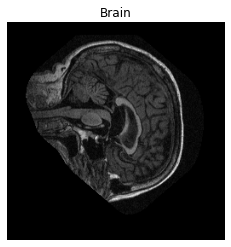

In [18]:
import nibabel as nib # We'll call nibabel nib for short as we'll be calling it lots
from nibabel.processing import resample_from_to 
import matplotlib.pyplot as plt # Same idea here, I'm lazy and don't want ot type loads of letters every time I want to make a plot

# Now we're going to import an anatomical image of the brain. The `t1_img` variable contains all the information relevant to this nifti image, things like its voxels array, its affine transform and its voxel sizes are all stored here.


t1_img = nib.load('OASIS1/OAS1_0001_MR1/RAW/OAS1_0001_MR1_mpr-4_anon.hdr') # Import the data. Scaling='fp' is the equievlent of the -f flag in ptoa
t1_voxels = t1_img.get_fdata() # Get a 3D array of voxels

plt.imshow(t1_voxels[:, :, t1_voxels.shape[2]//2], cmap='gray') # Show the central axial slice
plt.title('Brain') # Give the plot a title
plt.axis(False) # Turn off the axis
plt.show() # Show the plot

In [25]:
t1_hdr = t1_img.header # Get the images header
zoom = t1_hdr.get_zooms()
print('The voxels of this image are {0:.1f} x {1:.1f} x {2:.1f} mm'.format(*zoom)) # Print the size of each voxel to the console

t1_affine = t1_img.affine # We'll need this to save any output data. It tells us the mapping between the voxel space and scanner space

# Now we're going to load a mask we want to apply to our image. This mask was output by FreeSurfer so is already a `.nii.gz` file.



The voxels of this image are 1.0 x 1.0 x 1.2 mm


## 1/ Extract information from incomplete image

In [66]:
#https://www.programcreek.com/python/?CodeExample=read+gif
import PIL
import numpy as np
def readGif(filename, asNumpy=True):
    """ readGif(filename, asNumpy=True)
    
    Read images from an animated GIF file.  Returns a list of numpy 
    arrays, or, if asNumpy is false, a list if PIL images.
    
    """
    
    # Check PIL
    if PIL is None:
        raise RuntimeError("Need PIL to read animated gif files.")
    
    # Check Numpy
    if np is None:
        raise RuntimeError("Need Numpy to read animated gif files.")
    
    # Check whether it exists
    if not os.path.isfile(filename):
        raise IOError('File not found: '+str(filename))
    
    # Load file using PIL
    pilIm = PIL.Image.open(filename)    
    pilIm.seek(0)
    
    # Read all images inside
    images = []
    try:
        while True:
            # Get image as numpy array
            tmp = pilIm.convert() # Make without palette
            a = np.asarray(tmp)
            if len(a.shape)==0:
                raise MemoryError("Too little memory to convert PIL image to array")
            # Store, and next
            images.append(a)
            pilIm.seek(pilIm.tell()+1)
    except EOFError:
        pass
    
    # Convert to normal PIL images if needed
    if not asNumpy:
        images2 = images
        images = []
        for im in images2:            
            images.append( PIL.Image.fromarray(im) )
    
    # Done
    return images 

In [ ]:
from PIL import Image

from PIL import GifImagePlugin

import os
from os import listdir
import time

imagesList = listdir('OASIS1')
def loadImagesGif(path):
    imagesList = listdir(path)
    loadedImages = []
    masks = []
    
    for image in imagesList:
        if image == '.DS_Store':
            continue
        newPaths = listdir(path + "/" + image + "/RAW")
        for p in newPaths:
            images = []
            voxels = []
            name, ext = os.path.splitext(p) # to find gif files among all files
            if ext == '.gif':
                t1_img = readGif(path + "/" + image + "/RAW/" + p) # Import the data. Scaling='fp' is the equievlent of the -f flag in ptoa
                
                images.append(t1_img) # all images of a folder are stored in a list
                time.sleep(5)
               
            
        loadedImages.append(images)
        #imageVoxels.append(voxels)
        newPaths1 = listdir(path + "/" + image + "/FSL_SEG")
        for m in newPaths1:
            name, ext = os.path.splitext(m)
            if ext == '.gif':
                mask = readGif(path + "/" + image + "/FSL_SEG/" + m)
                masks.append(mask)
              #  time.sleep(5)
    return loadedImages, masks 
                


                
imagesDataGif, maskDataGif = loadImagesGif ('OASIS1')

       

In [88]:
len(imagesDataGif[24])

1

In [52]:
import numpy as np
from numpy.fft import fftshift, ifftshift, fftn, ifftn

def transform_kspace_to_image(k, dim=None, img_shape=None):
    """ Computes the Fourier transform from k-space to image space
    along a given or all dimensions
    :param k: k-space data
    :param dim: vector of dimensions to transform
    :param img_shape: desired shape of output image
    :returns: data in image space (along transformed dimensions)
    """
    if not dim:
        dim = range(k.ndim)

    img = fftshift(ifftn(ifftshift(k, axes=dim), s=img_shape, axes=dim), axes=dim)
    img *= np.sqrt(np.prod(np.take(img.shape, dim)))
    return img


def transform_image_to_kspace(img, dim=None, k_shape=None):
    """ Computes the Fourier transform from image space to k-space space
    along a given or all dimensions
    :param img: image space data
    :param dim: vector of dimensions to transform
    :param k_shape: desired shape of output k-space data
    :returns: data in k-space (along transformed dimensions)
    """
    if not dim:
        dim = range(img.ndim)

    k = fftshift(fftn(ifftshift(img, axes=dim), s=k_shape, axes=dim), axes=dim)
    k /= np.sqrt(np.prod(np.take(img.shape, dim)))
    return k

In [55]:
# Reading an animated GIF file using Python Image Processing Library - Pillow

from PIL import Image

from PIL import GifImagePlugin

 

imageObject = Image.open("OASIS1/OAS1_0001_MR1/RAW/OAS1_0001_MR1_mpr-1_anon_sag_66.gif")
img_arr = np.array(imageObject)

k_image = transform_image_to_kspace(img_arr)
print(img_arr.shape)



(256, 256)


In [56]:
k_image

array([[-0.3046875 +0.j        ,  0.42387155-7.53812587j,
        -0.39245334-4.409622j  , ..., -3.56064022+1.54208952j,
        -0.39245334+4.409622j  ,  0.42387155+7.53812587j],
       [ 0.09814306+1.51789783j,  1.22497813-2.04024897j,
        -2.31796005-2.32399349j, ..., -4.39232468-1.72835789j,
        -1.3602197 +1.0014344j , -1.38334591+5.91744381j],
       [ 0.53506511-1.34705643j,  2.0291962 -0.7986021j ,
        -0.25727713+1.43204561j, ..., -1.26719817+0.69131187j,
         0.59141834+2.88566752j, -0.61322079+2.97431924j],
       ...,
       [ 2.12449693+3.22480803j,  5.04753502-0.3338351j ,
         4.03416703-2.03797956j, ...,  0.9251646 -2.53926009j,
        -0.95198834+0.57953688j, -0.08872413+3.32366895j],
       [ 0.53506511+1.34705643j, -0.61322079-2.97431924j,
         0.59141834-2.88566752j, ...,  0.28220643-2.79004791j,
        -0.25727713-1.43204561j,  2.0291962 +0.7986021j ],
       [ 0.09814306-1.51789783j, -1.38334591-5.91744381j,
        -1.3602197 -1.0014344j

In [57]:
img_arr = img_arr - 180
new_img = Image.fromarray(img_arr)
new_img.save("altered_test.png")

In [85]:
imageObject = readGif("OASIS1/OAS1_0005_MR1/RAW/OAS1_0005_MR1_mpr-1_anon_sag_66.gif")

In [86]:
imageObject

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)]

In [87]:
new_img = Image.fromarray(imageObject[0])
new_img.save("altered_test1.png")

In [ ]:
image_data = image.get_fdata()

In [ ]:
image_data.shape

In [ ]:
import os
import numpy as np
from PIL import Image
from keras.utils import Sequence
#from skimage.io import imread


def load_data(nr_of_channels, batch_size=1, nr_A_train_imgs=None, nr_B_train_imgs=None,
              nr_A_test_imgs=None, nr_B_test_imgs=None, subfolder='',
              generator=False, D_model=None, use_multiscale_discriminator=False, use_supervised_learning=False, REAL_LABEL=1.0):

    trainA_path = os.path.join('data', subfolder, 'trainA')
    trainB_path = os.path.join('data', subfolder, 'trainB')
    testA_path = os.path.join('data', subfolder, 'testA')
    testB_path = os.path.join('data', subfolder, 'testB')

    trainA_image_names = os.listdir(trainA_path)
    if nr_A_train_imgs != None:
        trainA_image_names = trainA_image_names[:nr_A_train_imgs]

    trainB_image_names = os.listdir(trainB_path)
    if nr_B_train_imgs != None:
        trainB_image_names = trainB_image_names[:nr_B_train_imgs]

    testA_image_names = os.listdir(testA_path)
    if nr_A_test_imgs != None:
        testA_image_names = testA_image_names[:nr_A_test_imgs]

    testB_image_names = os.listdir(testB_path)
    if nr_B_test_imgs != None:
        testB_image_names = testB_image_names[:nr_B_test_imgs]

    if generator:
        return data_sequence(trainA_path, trainB_path, trainA_image_names, trainB_image_names, batch_size=batch_size)  # D_model, use_multiscale_discriminator, use_supervised_learning, REAL_LABEL)
    else:
        trainA_images = create_image_array(trainA_image_names, trainA_path, nr_of_channels)
        trainB_images = create_image_array(trainB_image_names, trainB_path, nr_of_channels)
        testA_images = create_image_array(testA_image_names, testA_path, nr_of_channels)
        testB_images = create_image_array(testB_image_names, testB_path, nr_of_channels)
        return {"trainA_images": trainA_images, "trainB_images": trainB_images,
                "testA_images": testA_images, "testB_images": testB_images,
                "trainA_image_names": trainA_image_names,
                "trainB_image_names": trainB_image_names,
                "testA_image_names": testA_image_names,
                "testB_image_names": testB_image_names}


def create_image_array(image_list, image_path, nr_of_channels):
    image_array = []
    for image_name in image_list:
        if image_name[-1].lower() == 'g':  # to avoid e.g. thumbs.db files
            if nr_of_channels == 1:  # Gray scale image -> MR image
                image = np.array(Image.open(os.path.join(image_path, image_name)))
                image = image[:, :, np.newaxis]
            else:                   # RGB image -> 3 channels
                image = np.array(Image.open(os.path.join(image_path, image_name)))
            image = normalize_array(image)
            image_array.append(image)

    return np.array(image_array)
  
  
  # If using 16 bit depth images, use the formula 'array = array / 32767.5 - 1' instead
def normalize_array(array):
    array = array / 127.5 - 1
    return array


class data_sequence(Sequence):

    def __init__(self, trainA_path, trainB_path, image_list_A, image_list_B, batch_size=1):  # , D_model, use_multiscale_discriminator, use_supervised_learning, REAL_LABEL):
        self.batch_size = batch_size
        self.train_A = []
        self.train_B = []
        for image_name in image_list_A:
            if image_name[-1].lower() == 'g':  # to avoid e.g. thumbs.db files
                self.train_A.append(os.path.join(trainA_path, image_name))
        for image_name in image_list_B:
            if image_name[-1].lower() == 'g':  # to avoid e.g. thumbs.db files
                self.train_B.append(os.path.join(trainB_path, image_name))

    def __len__(self):
        return int(max(len(self.train_A), len(self.train_B)) / float(self.batch_size))

    def __getitem__(self, idx):  # , use_multiscale_discriminator, use_supervised_learning):if loop_index + batch_size >= min_nr_imgs:
        if idx >= min(len(self.train_A), len(self.train_B)):
            # If all images soon are used for one domain,
            # randomly pick from this domain
            if len(self.train_A) <= len(self.train_B):
                indexes_A = np.random.randint(len(self.train_A), size=self.batch_size)
                batch_A = []
                for i in indexes_A:
                    batch_A.append(self.train_A[i])
                batch_B = self.train_B[idx * self.batch_size:(idx + 1) * self.batch_size]
            else:
                indexes_B = np.random.randint(len(self.train_B), size=self.batch_size)
                batch_B = []
                for i in indexes_B:
                    batch_B.append(self.train_B[i])
                batch_A = self.train_A[idx * self.batch_size:(idx + 1) * self.batch_size]
        else:
            batch_A = self.train_A[idx * self.batch_size:(idx + 1) * self.batch_size]
            batch_B = self.train_B[idx * self.batch_size:(idx + 1) * self.batch_size]

        real_images_A = create_image_array(batch_A, '', 3)
        real_images_B = create_image_array(batch_B, '', 3)

        return real_images_A, real_images_B  # input_data, target_data

In [ ]:
def extractInformation(image):
    cv2
    return

/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  


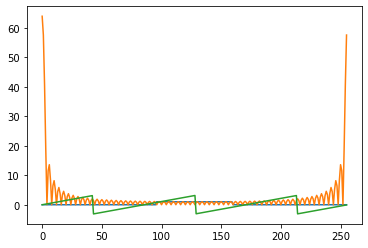

In [1]:
import numpy as np
import matplotlib.pyplot as plt

mx = np.zeros([256,1])
mx[96:128+32] = 1
plt.plot(mx)

ksp = np.fft.fft(mx,axis=0)
plt.plot(np.abs(ksp))

k = np.zeros(ksp.shape);

# voxel #2 and #3 were mis-placed using an imperfect gradient 
k[3] = ksp[3]+ksp[2]; 

rec = np.fft.ifft(k,axis=0);
phase = np.angle(rec)
# it's a straight line after unwrapping
plt.plot(np.angle(rec)) 

In [ ]:
import pydicom as dicom
import PIL # optional
import pandas as pd
import matplotlib.pyplot as plt

# specify your image path
image_path = 'xray.dcm'
ds = dicom.dcmread(image_path)
plt.imshow( ds.pixel_array)

plt.show()